### load libraries

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

import requests
import json

### get the Taste Profile subset from the Million Song Dataset (MSD) online

Source: http://millionsongdataset.com/tasteprofile/

(scroll down and use the link for TRIPLETS FOR 1M USERS)

Note: you used to be able to get this data via the Echo Nest API, however that no longer works since they got acquired by Spotify....

### unzip the downloaded .txt file into THIS directory so we can load it with PANDAS

In [3]:
taste_df = pd.read_csv('train_triplets.txt', sep='\t', header=None, names=['userID', 'songID', 'playcount'])
taste_df.head()

,userID,songID,playcount
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


In [4]:
print(len(taste_df), 'rows') #sanity check #rows, should be 48,373,586 according to the website
print(len(taste_df['songID'].unique()), 'unique songs') #should be 384,546

48373586 rows
384546 unique songs


### let's get the song title and artist name for each song ID

Source: http://millionsongdataset.com/pages/getting-dataset/ (scroll down to Additional Files, #1: List of all track Echo Nest ID)

Save this .txt file in the current directory as well

In [5]:
tracks_df = pd.read_csv('unique_tracks.txt', sep='<SEP>', header=None, names=['trackID', 'songID', 'artist', 'title'])
tracks_df.head()

C:\Users\sophi\AppData\Local\Temp\ipykernel_5360\4145821792.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tracks_df = pd.read_csv('unique_tracks.txt', sep='<SEP>', header=None, names=['trackID', 'songID', 'artist', 'title'])


,trackID,songID,artist,title
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens


In [6]:
print(len(tracks_df), 'rows') #should be 1 mill

1000000 rows


Note: the way this data is structured, a "track" is the unique instance/recording of a song. Thus one "song" can have multiple tracks (recordings) associated with it. For the purposes of this analysis, we only want to keep the unique SONGS.

Find and remove duplicate songs:

In [8]:
unique_songs_df = tracks_df[np.logical_not(tracks_df.duplicated(subset=['songID'], keep='first'))]
unique_songs_df.reset_index(inplace=True, drop=True)
unique_songs_df.head()

,trackID,songID,artist,title
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens


In [9]:
unique_songs_df.duplicated(subset=['songID']).sum() #check that this worked

0

### merge dataframes

Add the trackID, artist, and title for each entry in the taste dataframe

In [10]:
taste_df_merged = taste_df.merge(unique_songs_df, how='left', on='songID')
taste_df_merged.head()

,userID,songID,playcount,trackID,artist,title
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,TRIRLYL128F42539D1,Billy Preston,Nothing from Nothing
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,TRMHBXZ128F4238406,Paco De Lucia,Entre Dos Aguas
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,TRYQMNI128F147C1C7,Josh Rouse,Under Cold Blue Stars
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,TRAHZNE128F9341B86,The Dead 60s,Riot Radio (Soundtrack Version)


In [11]:
#sanity check: the dimensions of merged dataframe should be the same as the original taste dataframe
print(len(taste_df_merged), 'rows')
print(len(taste_df_merged['songID'].unique()), 'unique songs')
print(len(taste_df_merged['trackID'].unique()), 'unique tracks')

48373586 rows
384546 unique songs
384546 unique tracks


### check for missing values?

In [12]:
taste_df_merged.isna().values.any() #do we have any missing values?

True

In [13]:
#where? which column?
for i in range(0,6):
    print('NAs in col ', i, '?: ', taste_df_merged.iloc[:,i].isna().values.any())

NAs in col  0 ?:  False
NAs in col  1 ?:  False
NAs in col  2 ?:  False
NAs in col  3 ?:  False
NAs in col  4 ?:  False
NAs in col  5 ?:  True


Text(0.5, 1.0, 'Visualize missing data from MSD')

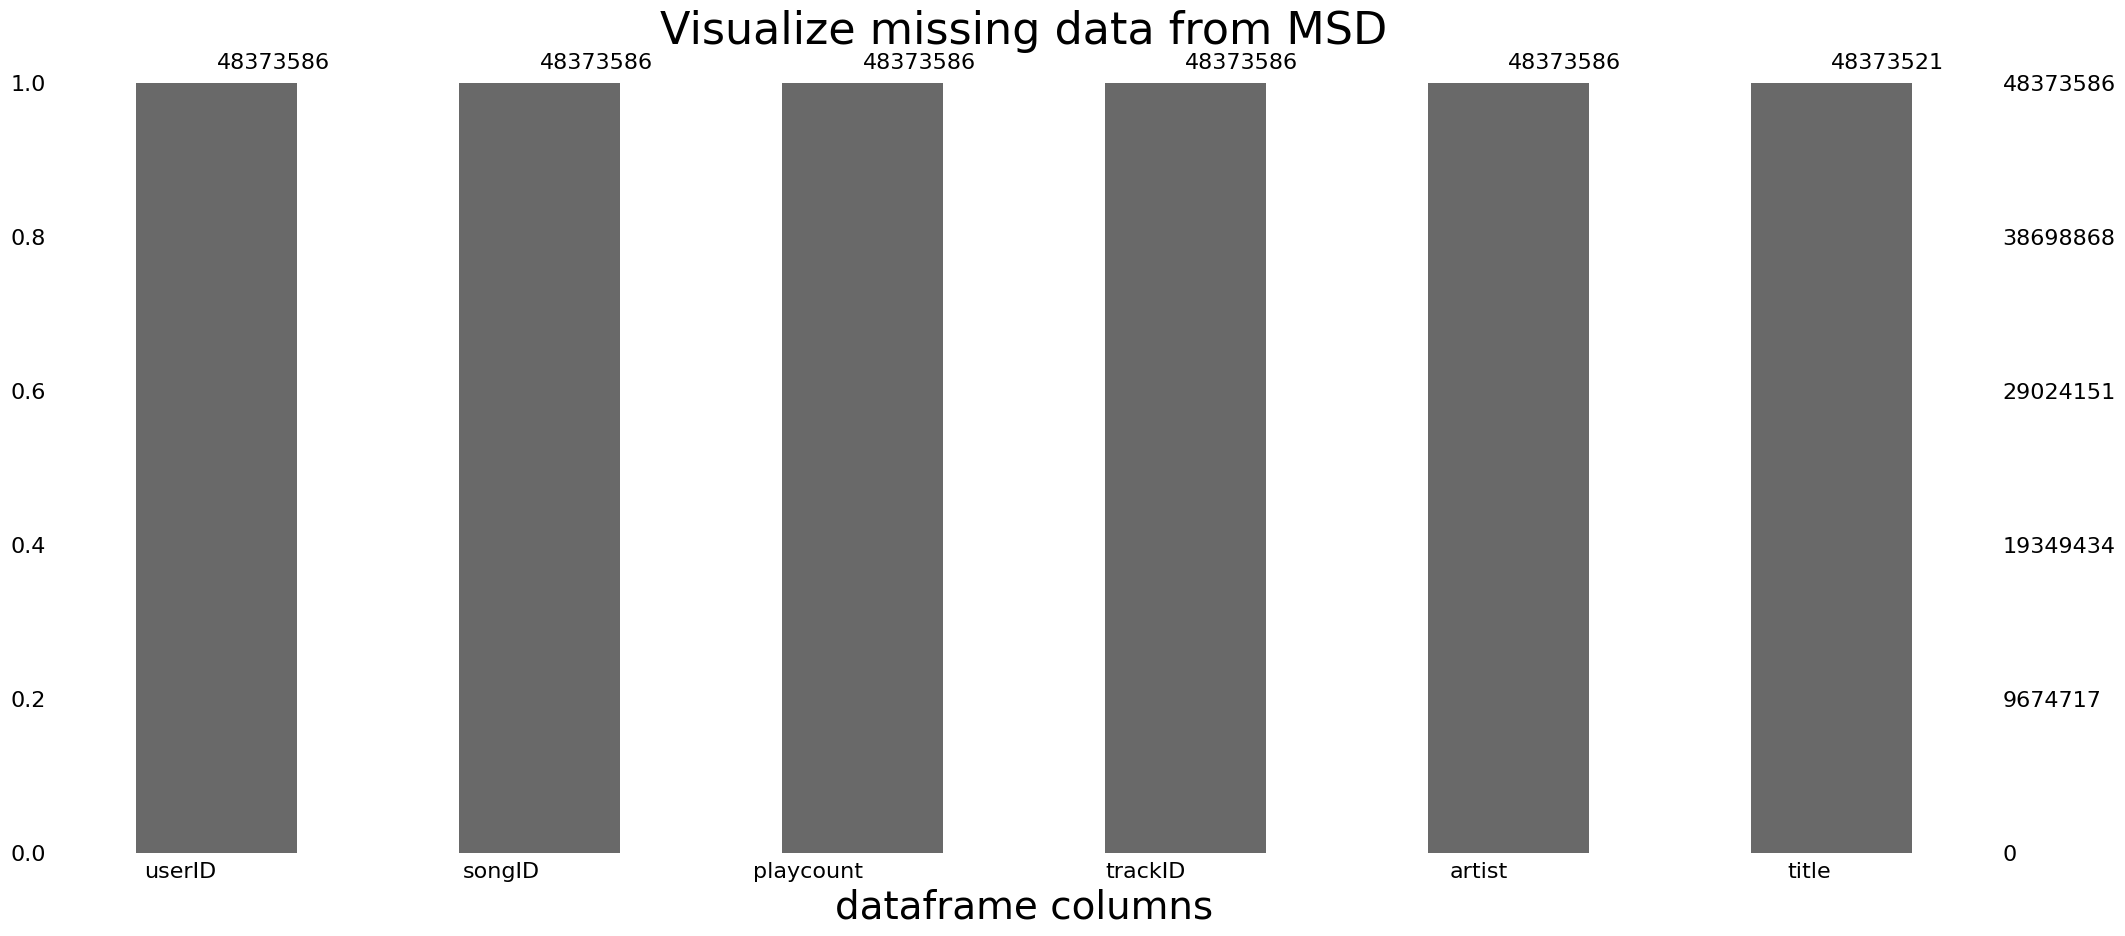

In [14]:
#lets visualize this
plot = msno.bar(taste_df_merged, label_rotation=0)
plot.set_xlabel('dataframe columns', fontsize=28)
plot.set_title('Visualize missing data from MSD', fontsize=32)

what songs/tracks/artists are affected?

In [15]:
taste_df_merged['songID'][taste_df_merged.iloc[:,5].isna()].unique()

array(['SOZDBDL12AB018AFFF', 'SOLDTFD12AB018AFE6', 'SOFDILP12AC960A4EF',
       'SOECGBQ12AB018D582'], dtype=object)

In [16]:
taste_df_merged['trackID'][taste_df_merged.iloc[:,5].isna()].unique()

array(['TROFVVS12903CDCA87', 'TRBXMXG12903CDCA7F', 'TRJOMUD12903CED473',
       'TRLKLLK12903CDCAA2'], dtype=object)

In [17]:
taste_df_merged['artist'][taste_df_merged.iloc[:,5].isna()].unique()

array(['Sébastien Roch', 'Fobia'], dtype=object)

seems like the problem stems from 4 songs / 2 artists. since this is an extremely small amount of data compared to what we have (65 rows vs. 48+ mill) let's remove these rows from the dataset so that what we have left is all equivalent amounts of information.

In [19]:
taste_df_cleaned = taste_df_merged.dropna()
taste_df_cleaned.reset_index(inplace=True, drop=True)
taste_df_cleaned

,userID,songID,playcount,trackID,artist,title
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,TRIRLYL128F42539D1,Billy Preston,Nothing from Nothing
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,TRMHBXZ128F4238406,Paco De Lucia,Entre Dos Aguas
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,TRYQMNI128F147C1C7,Josh Rouse,Under Cold Blue Stars
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,TRAHZNE128F9341B86,The Dead 60s,Riot Radio (Soundtrack Version)
...,...,...,...,...,...,...
48373516,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUHHHH12AF729E4AF,2,TRKUAEO128F933ABFC,Eminem / Obie Trice / Stat Quo / Bobby Creekwa...,We're Back
48373517,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUJVIT12A8C1451C1,1,TRRNFHH128F92D262D,Rise Against,Savior
48373518,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUSMXX12AB0185C24,1,TRSLDDC12903CC36E7,Usher featuring will.i.am,OMG
48373519,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOWYSKH12AF72A303A,3,TRNJQAM128F14557AF,matchbox twenty,Downfall (Album Version)


### checkpoint: save the merged dataset

In [ ]:
taste_df_cleaned.to_csv('taste_profiles.csv')

### exploration: what does the dataset look like so far?

1) the PLAYCOUNT variable

In [20]:
taste_df_cleaned['playcount'].describe()

count    4.837352e+07
mean     2.866854e+00
std      6.437698e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      9.667000e+03
Name: playcount, dtype: float64

Note the max

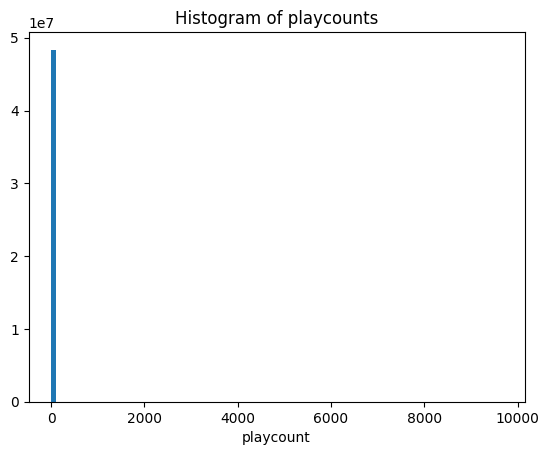

In [53]:
fig, axs = plt.subplots(1, 1)
N, bins, patches = axs.hist(taste_df_cleaned['playcount'].values, bins=100)
axs.set_xlabel('playcount')
axs.set_title('Histogram of playcounts')
plt.savefig('FIGURES/playcounts.png', dpi=300)
plt.show()

the amount of playcounts < 100 is completely overwhelming in the dataset (by several orders of magnitude)
lets zoom in to see more of the rest of the distribution...

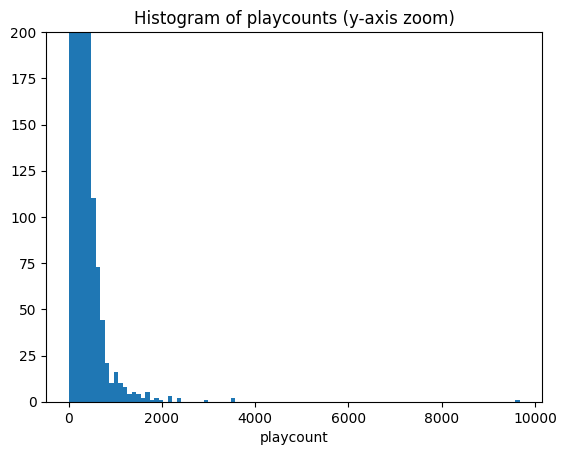

In [54]:
fig, axs = plt.subplots(1, 1)
N, bins, patches = axs.hist(taste_df_cleaned['playcount'].values, bins=100)
axs.set_ylim(ymin=0, ymax=200)
axs.set_xlabel('playcount')
axs.set_title('Histogram of playcounts (y-axis zoom)')
plt.savefig('FIGURES/playcounts-zoom.png', dpi=300)
plt.show()

now we can also see the max point in the data, near 10000 plays

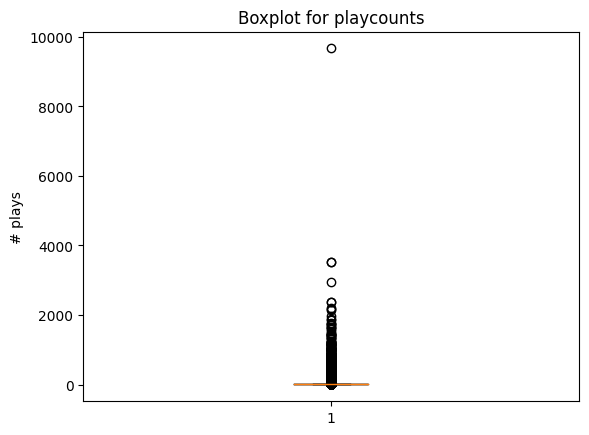

In [70]:
fig, axs = plt.subplots(1, 1)
axs.boxplot(taste_df_cleaned['playcount'].values)
axs.set_ylabel('# plays')
axs.set_title('Boxplot for playcounts')
plt.show()

In [74]:
#group the taste data by userID (take attribute means for each grouping)
users = taste_df_cleaned.groupby(['userID']).mean()
users.reset_index(inplace=True)
users.head()

C:\Users\sophi\AppData\Local\Temp\ipykernel_5360\2541209615.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,userID,playcount
0,00000b722001882066dff9d2da8a775658053ea0,1.083333
1,00001638d6189236866af9bbf309ae6c2347ffdc,4.000000
2,0000175652312d12576d9e6b84f600caa24c4715,1.583333
3,00001cf0dce3fb22b0df0f3a1d9cd21e38385372,1.388889
4,0000267bde1b3a70ea75cf2b2d216cb828e3202b,1.080000


this shows the avg. playcount of each users' data

In [76]:
users['playcount'].describe()

count    1.019318e+06
mean     3.120727e+00
std      3.292808e+00
min      1.000000e+00
25%      1.461538e+00
50%      2.177593e+00
75%      3.545455e+00
max      2.219000e+02
Name: playcount, dtype: float64

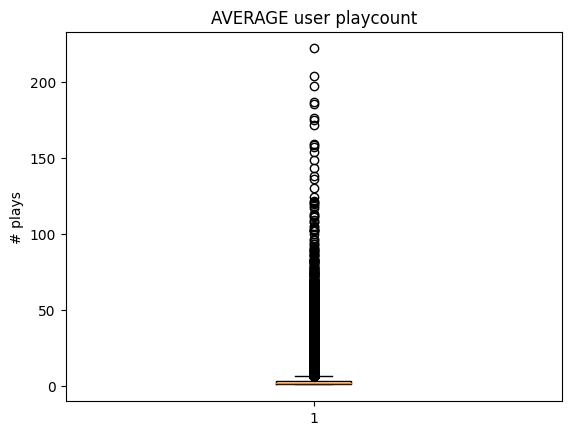

In [78]:
fig, axs = plt.subplots(1, 1)
axs.boxplot(users['playcount'].values)
axs.set_ylabel('# plays')
axs.set_title('AVERAGE user playcount')
plt.savefig('FIGURES/avg-user-playcount.png', dpi=300)
plt.show()

In [96]:
#group the taste data by userID (take attribute variance for each grouping)
users = taste_df_cleaned.groupby(['userID']).var()
users.reset_index(inplace=True)
users.head()

C:\Users\sophi\AppData\Local\Temp\ipykernel_5360\583724968.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,userID,playcount
0,00000b722001882066dff9d2da8a775658053ea0,0.083333
1,00001638d6189236866af9bbf309ae6c2347ffdc,37.076923
2,0000175652312d12576d9e6b84f600caa24c4715,1.356061
3,00001cf0dce3fb22b0df0f3a1d9cd21e38385372,0.251634
4,0000267bde1b3a70ea75cf2b2d216cb828e3202b,0.076667


this shows the variance in the playcounts of each user's data

In [97]:
users['playcount'].describe()

count    1.019318e+06
mean     4.505170e+01
std      1.062055e+03
min      0.000000e+00
25%      8.362084e-01
50%      3.946957e+00
75%      1.625758e+01
max      4.629729e+05
Name: playcount, dtype: float64

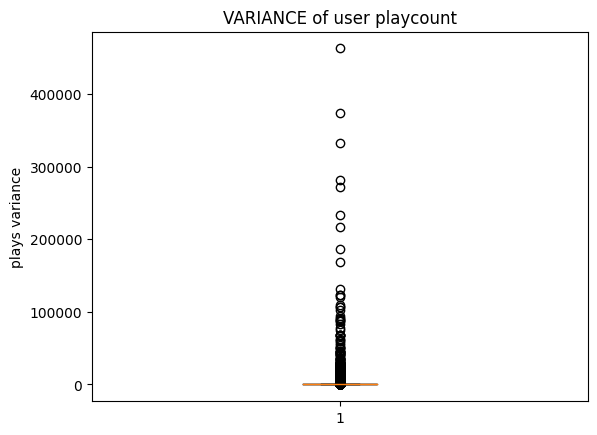

In [99]:
fig, axs = plt.subplots(1, 1)
axs.boxplot(users['playcount'].values)
axs.set_ylabel('plays variance')
axs.set_title('VARIANCE of user playcount')
plt.savefig('FIGURES/var-user-playcount.png', dpi=300)
plt.show()

2) how many observations/rows does each unique user have in the dataset?

In [58]:
#group the taste data by userID (take attribute counts for each grouping)
users = taste_df_cleaned.groupby(['userID']).count()
users.reset_index(inplace=True)
users.head()

,userID,songID,playcount,trackID,artist,title
0,00000b722001882066dff9d2da8a775658053ea0,12,12,12,12,12
1,00001638d6189236866af9bbf309ae6c2347ffdc,14,14,14,14,14
2,0000175652312d12576d9e6b84f600caa24c4715,12,12,12,12,12
3,00001cf0dce3fb22b0df0f3a1d9cd21e38385372,18,18,18,18,18
4,0000267bde1b3a70ea75cf2b2d216cb828e3202b,25,25,25,25,25


In [59]:
users['songID'].describe()

count    1.019318e+06
mean     4.745675e+01
std      5.781565e+01
min      1.000000e+01
25%      1.600000e+01
50%      2.700000e+01
75%      5.500000e+01
max      4.400000e+03
Name: songID, dtype: float64

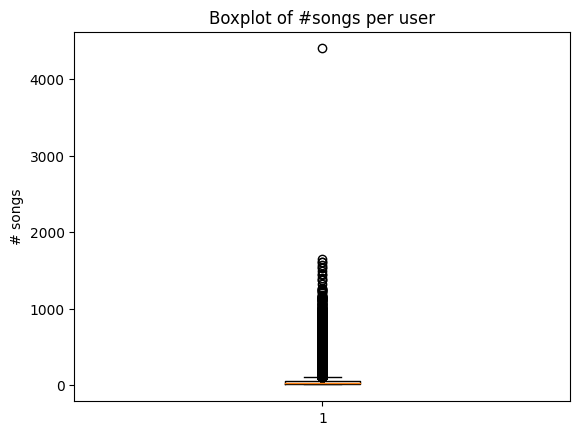

In [73]:
fig, axs = plt.subplots(1, 1)
axs.boxplot(users['songID'].values)
axs.set_ylabel('# songs')
axs.set_title('Boxplot of #songs per user')
plt.savefig('FIGURES/songs-per-user.png', dpi=300)
plt.show()

3) do all of these observations (songs) come from unique artists? or do some users have multiple songs by the same artist?

In [79]:
#group the taste data by userID AND artist (take attribute counts for each grouping)
users = taste_df_cleaned.groupby(['userID','artist']).count()
users.reset_index(inplace=True)
users.head()

,userID,artist,songID,playcount,trackID,title
0,00000b722001882066dff9d2da8a775658053ea0,Ana Carolina,1,1,1,1
1,00000b722001882066dff9d2da8a775658053ea0,Blue Man Group,1,1,1,1
2,00000b722001882066dff9d2da8a775658053ea0,Cartola,1,1,1,1
3,00000b722001882066dff9d2da8a775658053ea0,Edwyn Collins,1,1,1,1
4,00000b722001882066dff9d2da8a775658053ea0,Giles,1,1,1,1


In [80]:
users['title'].describe()

count    2.986490e+07
mean     1.619745e+00
std      2.257418e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      9.700000e+01
Name: title, dtype: float64

Note the max

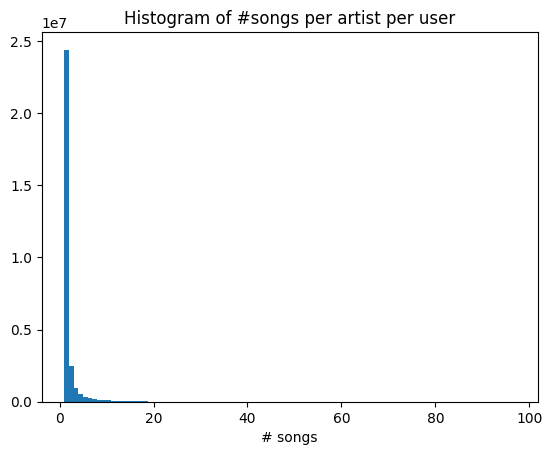

In [95]:
fig, axs = plt.subplots(1, 1)
N, bins, patches = axs.hist(users['title'].values, bins=97)
axs.set_xlabel('# songs')
axs.set_title('Histogram of #songs per artist per user')
plt.savefig('FIGURES/songs-per-artist-per-user.png', dpi=300)
plt.show()

Thoughts so far...

- the playcounts are heavily skewed towards the lower end of the range
- although it doesn't appear that there are any incorrect outliers, there do seem to be some outlier points towards the higher end of the range for both playcounts and songs per user
- because we are trying to analyze this data to describe individual preferences for each user, it may be problematic that not all users have the same amounts of data (i.e. observations/songs). we might need to filter the data to collect a more uniform distribution...
- because PLAYCOUNT might be a good analogue for "preference" (a song that is played a lot is likely to be more preferred than a song which has fewer plays), users whose data largely consists of low playcounts may be problemetic as well. we might need to filter the data using the variance of user playcounts to ensure there is a wide enough range in this variable

### data cleaning

first, lets remove users that have a really low variance in playcounts. for example, if someone has data where all the playcounts are just 1s or 2s (i.e. a bunch of songs that they just listened two one or two times) it's unclear if these songs are really preferred or not. additionally, if the variance of a user's playcounts is very low, we won't be able to use that variable to estimate a degree of preference (more vs less preferred) for any of their reported songs.

according to our exploration of the PLAYCOUNT variable, the variance ranges from 0 to 462,972 with a mean of ~45 and a median of ~4.

let's calculate some z-scores for the user playcount variance:

In [142]:
#group the taste data by userID (take attribute variance for each grouping)
users = taste_df_cleaned.groupby(['userID']).var()
users.reset_index(inplace=True)
users.rename(columns={'playcount':'playcount-var'}, inplace=True)
users.head()

C:\Users\sophi\AppData\Local\Temp\ipykernel_5360\3494991652.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,userID,playcount-var
0,00000b722001882066dff9d2da8a775658053ea0,0.083333
1,00001638d6189236866af9bbf309ae6c2347ffdc,37.076923
2,0000175652312d12576d9e6b84f600caa24c4715,1.356061
3,00001cf0dce3fb22b0df0f3a1d9cd21e38385372,0.251634
4,0000267bde1b3a70ea75cf2b2d216cb828e3202b,0.076667


In [143]:
#add a column for the zscored attribute
users['playcount-z'] = 0
users.head()

,userID,playcount-var,playcount-z
0,00000b722001882066dff9d2da8a775658053ea0,0.083333,0
1,00001638d6189236866af9bbf309ae6c2347ffdc,37.076923,0
2,0000175652312d12576d9e6b84f600caa24c4715,1.356061,0
3,00001cf0dce3fb22b0df0f3a1d9cd21e38385372,0.251634,0
4,0000267bde1b3a70ea75cf2b2d216cb828e3202b,0.076667,0


In [145]:
#calculate zscores
users.loc[:,'playcount-z'] = (users['playcount-var'].values-users['playcount-var'].mean())/users['playcount-var'].std()
users.head()

,userID,playcount-var,playcount-z
0,00000b722001882066dff9d2da8a775658053ea0,0.083333,-0.042341
1,00001638d6189236866af9bbf309ae6c2347ffdc,37.076923,-0.007509
2,0000175652312d12576d9e6b84f600caa24c4715,1.356061,-0.041143
3,00001cf0dce3fb22b0df0f3a1d9cd21e38385372,0.251634,-0.042182
4,0000267bde1b3a70ea75cf2b2d216cb828e3202b,0.076667,-0.042347


In [146]:
users['playcount-z'].describe()

count    1.019318e+06
mean    -1.469612e-17
std      1.000000e+00
min     -4.241935e-02
25%     -4.163200e-02
50%     -3.870301e-02
75%     -2.711170e-02
max      4.358792e+02
Name: playcount-z, dtype: float64

because the data aren't normally distributed, the common practices for zscore outlier detection won't as easily apply. so perhaps we need another method for cleaning.

first, lets remove users with a playcount variance of zero, because this means there is absolutely no range of their playcounts and that data will not be accurate/useable

In [147]:
users['toRemove'] = False #create a column to mark users to remove
users.head()

,userID,playcount-var,playcount-z,toRemove
0,00000b722001882066dff9d2da8a775658053ea0,0.083333,-0.042341,False
1,00001638d6189236866af9bbf309ae6c2347ffdc,37.076923,-0.007509,False
2,0000175652312d12576d9e6b84f600caa24c4715,1.356061,-0.041143,False
3,00001cf0dce3fb22b0df0f3a1d9cd21e38385372,0.251634,-0.042182,False
4,0000267bde1b3a70ea75cf2b2d216cb828e3202b,0.076667,-0.042347,False


In [148]:
users.loc[users['playcount-var']==0,'toRemove'] = True
print(len(users[users['toRemove']==True]), "users marked to remove")

38467 users marked to remove


In [149]:
#drop the playcount-var column and merge this information back to the main tastes dataset
users.drop(columns=['playcount-var', 'playcount-z'], inplace=True)
users.head()

,userID,toRemove
0,00000b722001882066dff9d2da8a775658053ea0,False
1,00001638d6189236866af9bbf309ae6c2347ffdc,False
2,0000175652312d12576d9e6b84f600caa24c4715,False
3,00001cf0dce3fb22b0df0f3a1d9cd21e38385372,False
4,0000267bde1b3a70ea75cf2b2d216cb828e3202b,False


In [150]:
taste_df_dropped = taste_df_cleaned.merge(users, how='left', on='userID')
taste_df_dropped.head()

,userID,songID,playcount,trackID,artist,title,toRemove
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove,False
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,TRIRLYL128F42539D1,Billy Preston,Nothing from Nothing,False
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,TRMHBXZ128F4238406,Paco De Lucia,Entre Dos Aguas,False
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,TRYQMNI128F147C1C7,Josh Rouse,Under Cold Blue Stars,False
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,TRAHZNE128F9341B86,The Dead 60s,Riot Radio (Soundtrack Version),False


In [153]:
#sanity check: the dimensions of merged dataframe should be the same as the original taste dataframe
print(len(taste_df_dropped), 'rows')
print(len(taste_df_dropped['songID'].unique()), 'unique songs')
print(len(taste_df_dropped['trackID'].unique()), 'unique tracks')
print(len(taste_df_dropped[taste_df_dropped['toRemove']==True]['userID'].unique()), "users marked to remove")
print(len(taste_df_dropped[taste_df_dropped['toRemove']==True]), "datapoints marked to remove")
print("")
print((len(taste_df_dropped)-len(taste_df_dropped[taste_df_dropped['toRemove']==True]))/len(taste_df), "of original amount of data remaining")

48373521 rows
384542 unique songs
384542 unique tracks
38467 users marked to remove
620643 datapoints marked to remove

0.987168451807563 of original amount of data remaining


In [156]:
#remove the rows marked by the toRemove column
taste_df_dropped.drop(index=taste_df_dropped[taste_df_dropped['toRemove']==True].index, inplace=True)
taste_df_dropped.reset_index(inplace=True, drop=True)
taste_df_dropped

,userID,songID,playcount,trackID,artist,title,toRemove
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove,False
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,TRIRLYL128F42539D1,Billy Preston,Nothing from Nothing,False
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,TRMHBXZ128F4238406,Paco De Lucia,Entre Dos Aguas,False
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,TRYQMNI128F147C1C7,Josh Rouse,Under Cold Blue Stars,False
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,TRAHZNE128F9341B86,The Dead 60s,Riot Radio (Soundtrack Version),False
...,...,...,...,...,...,...,...
47752873,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUHHHH12AF729E4AF,2,TRKUAEO128F933ABFC,Eminem / Obie Trice / Stat Quo / Bobby Creekwa...,We're Back,False
47752874,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUJVIT12A8C1451C1,1,TRRNFHH128F92D262D,Rise Against,Savior,False
47752875,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUSMXX12AB0185C24,1,TRSLDDC12903CC36E7,Usher featuring will.i.am,OMG,False
47752876,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOWYSKH12AF72A303A,3,TRNJQAM128F14557AF,matchbox twenty,Downfall (Album Version),False


In [158]:
#remove the toRemove column now since it is all false
taste_df_dropped.drop(columns=['toRemove'], inplace=True)
taste_df_dropped.head()

,userID,songID,playcount,trackID,artist,title
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,TRIRLYL128F42539D1,Billy Preston,Nothing from Nothing
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,TRMHBXZ128F4238406,Paco De Lucia,Entre Dos Aguas
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,TRYQMNI128F147C1C7,Josh Rouse,Under Cold Blue Stars
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,TRAHZNE128F9341B86,The Dead 60s,Riot Radio (Soundtrack Version)


through doing this, we have only removed less than 2% of our original data (including that which was NAN from earlier).

let's remove users that have a max playcount of less than 3. this allows us to remove some more users with unclear preference levels in their data (without getting rid of too much of the data).

In [164]:
#group the taste data by userID (take attribute maximum for each grouping)
users = taste_df_dropped[['userID','playcount']].groupby(['userID']).max()
users.reset_index(inplace=True)
users.rename(columns={'playcount':'playcount-max'}, inplace=True)
users.head()

,userID,playcount-max
0,00000b722001882066dff9d2da8a775658053ea0,2
1,00001638d6189236866af9bbf309ae6c2347ffdc,24
2,0000175652312d12576d9e6b84f600caa24c4715,4
3,00001cf0dce3fb22b0df0f3a1d9cd21e38385372,2
4,0000267bde1b3a70ea75cf2b2d216cb828e3202b,2


In [165]:
users['playcount-max'].describe()

count    980851.000000
mean         17.189182
std          30.164038
min           2.000000
25%           5.000000
50%          10.000000
75%          20.000000
max        9667.000000
Name: playcount-max, dtype: float64

In [167]:
users['toRemove'] = False #create a column to mark users to remove
users.head()

,userID,playcount-max,toRemove
0,00000b722001882066dff9d2da8a775658053ea0,2,False
1,00001638d6189236866af9bbf309ae6c2347ffdc,24,False
2,0000175652312d12576d9e6b84f600caa24c4715,4,False
3,00001cf0dce3fb22b0df0f3a1d9cd21e38385372,2,False
4,0000267bde1b3a70ea75cf2b2d216cb828e3202b,2,False


In [168]:
users.loc[users['playcount-max']<3,'toRemove'] = True
print(len(users[users['toRemove']==True]), "users marked to remove")

85746 users marked to remove


In [169]:
#drop the playcount-var column and merge this information back to the main tastes dataset
users.drop(columns=['playcount-max'], inplace=True)
users.head()

,userID,toRemove
0,00000b722001882066dff9d2da8a775658053ea0,True
1,00001638d6189236866af9bbf309ae6c2347ffdc,False
2,0000175652312d12576d9e6b84f600caa24c4715,False
3,00001cf0dce3fb22b0df0f3a1d9cd21e38385372,True
4,0000267bde1b3a70ea75cf2b2d216cb828e3202b,True


In [170]:
taste_df_dropped = taste_df_dropped.merge(users, how='left', on='userID')
taste_df_dropped.head()

,userID,songID,playcount,trackID,artist,title,toRemove
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove,False
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,TRIRLYL128F42539D1,Billy Preston,Nothing from Nothing,False
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,TRMHBXZ128F4238406,Paco De Lucia,Entre Dos Aguas,False
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,TRYQMNI128F147C1C7,Josh Rouse,Under Cold Blue Stars,False
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,TRAHZNE128F9341B86,The Dead 60s,Riot Radio (Soundtrack Version),False


In [171]:
#sanity check: the dimensions of merged dataframe should be the same as the original taste dataframe
print(len(taste_df_dropped), 'rows')
print(len(taste_df_dropped['songID'].unique()), 'unique songs')
print(len(taste_df_dropped['trackID'].unique()), 'unique tracks')
print(len(taste_df_dropped[taste_df_dropped['toRemove']==True]['userID'].unique()), "users marked to remove")
print(len(taste_df_dropped[taste_df_dropped['toRemove']==True]), "datapoints marked to remove")
print("")
print((len(taste_df_dropped)-len(taste_df_dropped[taste_df_dropped['toRemove']==True]))/len(taste_df), "of original amount of data remaining")

47752878 rows
384128 unique songs
384128 unique tracks
85746 users marked to remove
1959056 datapoints marked to remove

0.9466699863847183 of original amount of data remaining


In [172]:
#remove the rows marked by the toRemove column
taste_df_dropped.drop(index=taste_df_dropped[taste_df_dropped['toRemove']==True].index, inplace=True)
taste_df_dropped.reset_index(inplace=True, drop=True)
#remove the toRemove column now since it is all false
taste_df_dropped.drop(columns=['toRemove'], inplace=True)
taste_df_dropped

,userID,songID,playcount,trackID,artist,title
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,TRIRLYL128F42539D1,Billy Preston,Nothing from Nothing
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,TRMHBXZ128F4238406,Paco De Lucia,Entre Dos Aguas
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,TRYQMNI128F147C1C7,Josh Rouse,Under Cold Blue Stars
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,TRAHZNE128F9341B86,The Dead 60s,Riot Radio (Soundtrack Version)
...,...,...,...,...,...,...
45793817,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUHHHH12AF729E4AF,2,TRKUAEO128F933ABFC,Eminem / Obie Trice / Stat Quo / Bobby Creekwa...,We're Back
45793818,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUJVIT12A8C1451C1,1,TRRNFHH128F92D262D,Rise Against,Savior
45793819,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUSMXX12AB0185C24,1,TRSLDDC12903CC36E7,Usher featuring will.i.am,OMG
45793820,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOWYSKH12AF72A303A,3,TRNJQAM128F14557AF,matchbox twenty,Downfall (Album Version)


through doing this, we are still left with ~95% of the original data, which is now more usable for the task at hand.

### checkpoint: save the cleaned dataset

In [173]:
taste_df_dropped.to_csv('taste_profiles_cleaned.csv')

In [2]:
taste_df_dropped = pd.read_csv('taste_profiles_cleaned.csv', index_col=0, header=0, dtype={'userID': str, 'songID': str, 
    'playcount': int, 'trackID': str, 'artist': str, 'title': str})

taste_df_dropped

,userID,songID,playcount,trackID,artist,title
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,TRIRLYL128F42539D1,Billy Preston,Nothing from Nothing
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,TRMHBXZ128F4238406,Paco De Lucia,Entre Dos Aguas
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,TRYQMNI128F147C1C7,Josh Rouse,Under Cold Blue Stars
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,TRAHZNE128F9341B86,The Dead 60s,Riot Radio (Soundtrack Version)
...,...,...,...,...,...,...
45793817,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUHHHH12AF729E4AF,2,TRKUAEO128F933ABFC,Eminem / Obie Trice / Stat Quo / Bobby Creekwa...,We're Back
45793818,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUJVIT12A8C1451C1,1,TRRNFHH128F92D262D,Rise Against,Savior
45793819,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUSMXX12AB0185C24,1,TRSLDDC12903CC36E7,Usher featuring will.i.am,OMG
45793820,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOWYSKH12AF72A303A,3,TRNJQAM128F14557AF,matchbox twenty,Downfall (Album Version)


### data cleaning TO DO: remove mismatch entries from MSD

more info here: http://millionsongdataset.com/blog/12-2-12-fixing-matching-errors/

### add to the dataset through the Spotify API

get additional meta data about the songs/artists that we have in the dataset

first we need to get the spotify uri for each song/artist

In [221]:
#collect the unique songs/artists that we have left in our dataframe
#which we need to look up using the spotify API
songs = taste_df_dropped.groupby(['songID', 'artist', 'title']).count()
songs.reset_index(inplace=True)
songs.drop(columns=['userID', 'playcount', 'trackID'], inplace=True)

#make columns to record the Spotify IDs for the track and the artist
#which we'll need later
songs['trackID_spot'] = ''
songs['artistID_spot'] = ''
songs.head()

,songID,artist,title,trackID_spot,artistID_spot
0,SOAAADD12AB018A9DD,Harold Budd,The Room Of Stairs,,
1,SOAAADE12A6D4F80CC,Dave Edmunds,(I'm Gonna Start) Living Again If It Kills Me ...,,
2,SOAAADF12A8C13DF62,LANDA DANIEL,KRYSAR (LIVE),,
3,SOAAADZ12A8C1334FB,Paul Cardall,Joy To The World,,
4,SOAAAFI12A6D4F9C66,I Love You But I've Chosen Darkness,The Less You See,,


authorization:

In [106]:
CLIENT_ID = ''
CLIENT_SECRET = ''

baseURL = 'https://accounts.spotify.com/authorize'
URLpost = {
    'client_id': CLIENT_ID,
    'response_type': 'code',
    'redirect_uri': 'https://csci5622/callback'
}

In [107]:
response1 = requests.get(baseURL, URLpost)

In [108]:
response1.status_code

200

In [109]:
AUTH_URL = 'https://accounts.spotify.com/api/token'

# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

In [110]:
auth_response

<Response [200]>

In [111]:
# convert the response to JSON
auth_response_data = auth_response.json()

# save the access token
access_token = auth_response_data['access_token']

In [112]:
headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
}

populate spotify IDs:

In [13]:
BASE_URL = 'https://api.spotify.com/v1/'

for i in range(24804, len(songs)): #start the range at 0 and then as errors come up adjust this to start where you left off
    #get names of tracks and artists from the songs dataframe we made above
    track = songs.iloc[i,2]
    artist = songs.iloc[i,1]
    
    #formulate the query and the request
    query = track + '%20artist:' + artist
    r = requests.get(BASE_URL + 'search?q=' + query + '&type=track' + '&limit=1', headers=headers)
    
    if r.status_code == 400: #usually happens if weird character in song/artist name, skip this
        continue
    elif r.status_code != 200: #if request is not successful, stop and report
        print("ERROR: STATUS CODE ", r.status_code)
        print(r)
        break
    elif r.json()['tracks']['total'] == 0: #if request is successful but no results found, skip entry and continue
        continue
    else: #save IDs to songs dataframe
        jsontxt = r.json()
        songs.iloc[i,3] = jsontxt['tracks']['items'][0]['id']
        songs.iloc[i,4] = jsontxt['tracks']['items'][0]['artists'][0]['id']
        
        print("STATUS: ROW ", i, "/", len(songs)) #print status

STATUS: ROW  24803 / 382448


In [6]:
songs.iloc[24795:24805,:]

,songID,artist,title,trackID_spot,artistID_spot,artistGenres,trackGenres,artistPop,trackPop,trackAcoustic,trackDanceable,trackDurMS,trackEnergy,trackInstrum,trackKey,trackLoud,trackMode,trackSpeech,trackTempo,trackVal
24795,SOBOIMB12A6D4F7ABA,Trisha Yearwood,Under The Rainbow,3WLK3F6XtyEyL7Xi4HjJx8,3XlIhgydjvC4EniPFZT20j,,,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
24796,SOBOINB12A8C13BCA1,The Human Abstract,Movement From Discord,2rVt2gf9XF7vXnnKOgtYZn,2SDGIFzEh9xmE5zDKcMRkj,,,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
24797,SOBOINW12A8C135CEF,The Reverend Peyton's Big Damn Band,Them Old Days Are Gone,1XTR3BR0A2BSbOBN2hKJte,6Ec85Uubz3lO7BIEvcBfZK,,,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
24798,SOBOIOR12A8C1332A4,Silverchair,Faultline,18ihvfYz6uiieilnfl4XCs,4iudEcmuPlYNdbP3e1bdn1,,,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
24799,SOBOIQD12A8C13B060,Bombshell Rocks,Unstoppable,6Do92hxiqSQza9fyW4nO1P,3mL3tecqNWwTIwi6qhvA6I,,,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
24800,SOBOISJ12A6D4F4AD9,3rd Force,Believe In Me (No Vocals / No DJ Edit),6EMvrGNjLVsHkiPIQnntxj,3t0v2PRYA41acAC7z17tSm,,,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
24801,SOBOITE12AB0187724,Freddy Fresh,Norbert's Working,5cPYLy0iGfn6tMYZ0eZ776,2jW8DcJLujtIgktWhDcB4L,,,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
24802,SOBOITP12A8C13B675,Pohlmann.,Dämon (Gib Mich Frei) (Münster Version),NaN,NaN,,,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
24803,SOBOIXF12AB017E1CA,Jeremy Camp,I'm Alive,5U41CBR4ctpnzfKcscJUEc,5wpEBloInversG3zp3CVAk,,,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
24804,SOBOIXK12A6D4F88C5,Latin Breed,Te Vas O Te Quedas,NaN,NaN,,,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0


### checkpoint: save spotify IDs

In [15]:
songs.to_csv('spotifyIDs.csv')

In [92]:
songs = pd.read_csv('spotifyIDs.csv', index_col=0, header=0, dtype={'songID': str, 'artist': str,
    'title': str, 'trackID_spot': str, 'artistID_spot': str})
songs.head()

,songID,artist,title,trackID_spot,artistID_spot
0,SOAAADD12AB018A9DD,Harold Budd,The Room Of Stairs,1oPJpjMvYEQJhqEDsYgHSh,3uOCouLFR4bVx0XeiQJSbl
1,SOAAADE12A6D4F80CC,Dave Edmunds,(I'm Gonna Start) Living Again If It Kills Me ...,NaN,NaN
2,SOAAADF12A8C13DF62,LANDA DANIEL,KRYSAR (LIVE),NaN,NaN
3,SOAAADZ12A8C1334FB,Paul Cardall,Joy To The World,6ECnCJjRWAfXZrRulSo4vk,7FQRbf8gbKw8KZQZAJWxH2
4,SOAAAFI12A6D4F9C66,I Love You But I've Chosen Darkness,The Less You See,5pvSPxfrhKFqaPPCKhRkcJ,15Rn3v2LgUxR0donJY8e1E


use the collected Spotify IDs to look up artist and track metadata and features

In [93]:
#add columns for attributes to add

#genre info
songs['artistGenres'] = ''

#popularity measure
songs['artistPop'] = 0
songs['trackPop'] = 0

#acoustic features
songs['trackAcoustic'] = 0.0
songs['trackDanceable'] = 0.0
songs['trackDurMS'] = 0
songs['trackEnergy'] = 0.0
songs['trackInstrum'] = 0.0
songs['trackKey'] = 0
songs['trackLoud'] = 0.0
songs['trackMode'] = 0
songs['trackSpeech'] = 0.0
songs['trackTempo'] = 0.0
songs['trackVal'] = 0.0

songs['albumYear'] = '' #release date

songs.head()

,songID,artist,title,trackID_spot,artistID_spot,artistGenres,trackGenres,artistPop,trackPop,trackAcoustic,trackDanceable,trackDurMS,trackEnergy,trackInstrum,trackKey,trackLoud,trackMode,trackSpeech,trackTempo,trackVal
0,SOAAADD12AB018A9DD,Harold Budd,The Room Of Stairs,1oPJpjMvYEQJhqEDsYgHSh,3uOCouLFR4bVx0XeiQJSbl,,,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
1,SOAAADE12A6D4F80CC,Dave Edmunds,(I'm Gonna Start) Living Again If It Kills Me ...,NaN,NaN,,,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
2,SOAAADF12A8C13DF62,LANDA DANIEL,KRYSAR (LIVE),NaN,NaN,,,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
3,SOAAADZ12A8C1334FB,Paul Cardall,Joy To The World,6ECnCJjRWAfXZrRulSo4vk,7FQRbf8gbKw8KZQZAJWxH2,,,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
4,SOAAAFI12A6D4F9C66,I Love You But I've Chosen Darkness,The Less You See,5pvSPxfrhKFqaPPCKhRkcJ,15Rn3v2LgUxR0donJY8e1E,,,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0


populate artist metadata. we're going to request multiple artists at the same time (50 maximum)

In [ ]:
BASE_URL = 'https://api.spotify.com/v1/'
artists = []
indices = []

for i in range(24800, len(songs)):
    if type(songs.iloc[i,4]) == str: #check that not NAN (will be float)
        artists.append(songs.iloc[i,4])
        indices.append(i)
        print("loading row ", i)
    if len(artists) == 50: #max capacity reached
        print('<<< GET >>>')
        #transform list into one string with IDs separated by commas only
        artistIDs = str(artists)[1:-1].translate({ord(c): None for c in '\''}).translate({ord(c): None for c in ' '})
        r = requests.get(BASE_URL + 'artists/?ids=' + artistIDs, headers=headers)
        
        if r.status_code != 200: #if request is not successful, stop and report
            print("ERROR: STATUS CODE ", r.status_code)
            print(r)
            break
        else: #save IDs to songs dataframe
            jsontxt = r.json()
            for j in range(0,50): #iterate through 50 returned artists
                if jsontxt['artists'][j] != None:
                    songs.iloc[indices[j],5] = str(jsontxt['artists'][j]['genres'])[1:-1].translate({ord(c): None for c in '\''})
                    songs.iloc[indices[j],6] = jsontxt['artists'][j]['popularity']

                print("STATUS: GOT ROW ", indices[j], "/", len(songs)) #print status
            artists = []
            indices = []

populate track metadata and features. request multiple tracks at a time (50 maximum)

In [ ]:
BASE_URL = 'https://api.spotify.com/v1/'
tracks = []
indices = []

for i in range(24800, len(songs)):
    if type(songs.iloc[i,3]) == str: #check that not NAN (will be float)
        tracks.append(songs.iloc[i,3])
        indices.append(i)
        print("loading row ", i)
    if len(tracks) == 50: #max capacity reached
        print('<<< GET >>>')
        #transform list into one string with IDs separated by commas only
        trackIDs = str(tracks)[1:-1].translate({ord(c): None for c in '\''}).translate({ord(c): None for c in ' '})
        r = requests.get(BASE_URL + 'tracks/?ids=' + trackIDs, headers=headers)
        
        if r.status_code != 200: #if request is not successful, stop and report
            print("ERROR: STATUS CODE ", r.status_code)
            print(r)
            break
        else: #save IDs to songs dataframe
            jsontxt = r.json()
            for j in range(0,50): #iterate through 50 returned tracks
                if jsontxt['tracks'][j] != None:
                    songs.iloc[indices[j],7] = jsontxt['tracks'][j]['popularity']
                    songs.iloc[indices[j],10] = jsontxt['tracks'][j]['duration_ms']
                    songs.iloc[indices[j],19] = jsontxt['tracks'][j]['album']['release_date']

                print("STATUS: GOT ROW ", indices[j], "/", len(songs)) #print status
            tracks = []
            indices = []

In [ ]:
BASE_URL = 'https://api.spotify.com/v1/'
tracks = []
indices = []

for i in range(24800, len(songs)):
    if type(songs.iloc[i,3]) == str: #check that not NAN (will be float)
        tracks.append(songs.iloc[i,3])
        indices.append(i)
        print("loading row ", i)
    if len(tracks) == 50: #max capacity reached
        print('<<< GET >>>')
        #transform list into one string with IDs separated by commas only
        trackIDs = str(tracks)[1:-1].translate({ord(c): None for c in '\''}).translate({ord(c): None for c in ' '})
        r = requests.get(BASE_URL + 'audio-features/?ids=' + trackIDs, headers=headers)
        
        if r.status_code != 200: #if request is not successful, stop and report
            print("ERROR: STATUS CODE ", r.status_code)
            print(r)
            break
        else: #save IDs to songs dataframe
            jsontxt = r.json()
            for j in range(0,50): #iterate through 50 returned tracks
                if jsontxt['audio_features'][j] != None:
                    songs.iloc[indices[j],8] = jsontxt['audio_features'][j]['acousticness']
                    songs.iloc[indices[j],9] = jsontxt['audio_features'][j]['danceability']
                    songs.iloc[indices[j],11] = jsontxt['audio_features'][j]['energy']
                    songs.iloc[indices[j],12] = jsontxt['audio_features'][j]['instrumentalness']
                    songs.iloc[indices[j],13] = jsontxt['audio_features'][j]['key']
                    songs.iloc[indices[j],14] = jsontxt['audio_features'][j]['loudness']
                    songs.iloc[indices[j],15] = jsontxt['audio_features'][j]['mode']
                    songs.iloc[indices[j],16] = jsontxt['audio_features'][j]['speechiness']
                    songs.iloc[indices[j],17] = jsontxt['audio_features'][j]['tempo']
                    songs.iloc[indices[j],18] = jsontxt['audio_features'][j]['valence']

                print("STATUS: GOT ROW ", indices[j], "/", len(songs)) #print status
            tracks = []
            indices = []

### checkpoint: save Spotify metadata

In [166]:
songs.to_csv('spotifyIDs.csv')

### merge the Spotify data back into the Tastes dataframe

In [177]:
songs.head()

,songID,artist,title,trackID_spot,artistID_spot,artistGenres,artistPop,trackPop,trackAcoustic,trackDanceable,trackDurMS,trackEnergy,trackInstrum,trackKey,trackLoud,trackMode,trackSpeech,trackTempo,trackVal,albumYear
0,SOAAADD12AB018A9DD,Harold Budd,The Room Of Stairs,1oPJpjMvYEQJhqEDsYgHSh,3uOCouLFR4bVx0XeiQJSbl,"ambient, american contemporary classical, art ...",60,10,0.8880,0.225,321133,0.135,0.657,3,-26.040,0,0.0382,81.807,0.0377,2000-08-04
1,SOAAADE12A6D4F80CC,Dave Edmunds,(I'm Gonna Start) Living Again If It Kills Me ...,NaN,NaN,,0,0,0.0000,0.000,0,0.000,0.000,0,0.000,0,0.0000,0.000,0.0000,
2,SOAAADF12A8C13DF62,LANDA DANIEL,KRYSAR (LIVE),NaN,NaN,,0,0,0.0000,0.000,0,0.000,0.000,0,0.000,0,0.0000,0.000,0.0000,
3,SOAAADZ12A8C1334FB,Paul Cardall,Joy To The World,6ECnCJjRWAfXZrRulSo4vk,7FQRbf8gbKw8KZQZAJWxH2,"lds, new age, new age piano",54,19,0.9890,0.422,133040,0.166,0.902,10,-14.307,1,0.0600,137.198,0.1220,1997-01-01
4,SOAAAFI12A6D4F9C66,I Love You But I've Chosen Darkness,The Less You See,5pvSPxfrhKFqaPPCKhRkcJ,15Rn3v2LgUxR0donJY8e1E,austindie,19,2,0.0824,0.446,243533,0.575,0.129,4,-6.577,0,0.0333,104.461,0.4270,2006-12-05


In [178]:
taste_df_dropped.head()

,userID,songID,playcount,trackID,artist,title
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,TRIRLYL128F42539D1,Billy Preston,Nothing from Nothing
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,TRMHBXZ128F4238406,Paco De Lucia,Entre Dos Aguas
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,TRYQMNI128F147C1C7,Josh Rouse,Under Cold Blue Stars
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,TRAHZNE128F9341B86,The Dead 60s,Riot Radio (Soundtrack Version)


In [175]:
taste_df_spotify = taste_df_dropped.merge(songs, how='left', on='songID')
taste_df_spotify

,userID,songID,playcount,trackID,artist_x,title_x,artist_y,title_y,trackID_spot,artistID_spot,...,trackDurMS,trackEnergy,trackInstrum,trackKey,trackLoud,trackMode,trackSpeech,trackTempo,trackVal,albumYear
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove,Jack Johnson,The Cove,NaN,NaN,...,0,0.000,0.000000,0,0.000,0,0.0000,0.000,0.000,
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,TRIRLYL128F42539D1,Billy Preston,Nothing from Nothing,Billy Preston,Nothing from Nothing,72PoJMDfdaw9gGECgA9kTZ,0IecGJbdBeYSOVtSPRehh5,...,156200,0.830,0.011200,9,-3.995,0,0.0283,102.800,0.909,1974-01-01
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,TRMHBXZ128F4238406,Paco De Lucia,Entre Dos Aguas,Paco De Lucia,Entre Dos Aguas,5hVqZ5hnvQGT4LOpUVuJUa,3h8OjAdgYXVRoMZ8jFd6Uw,...,360426,0.654,0.874000,4,-12.673,0,0.0349,102.814,0.924,1997-09-23
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,TRYQMNI128F147C1C7,Josh Rouse,Under Cold Blue Stars,Josh Rouse,Under Cold Blue Stars,4HWqzvmeiaddzCDkSQcNxf,38euc5ce2q2MMzaoJcPstz,...,196333,0.692,0.000008,1,-6.880,1,0.0266,100.614,0.523,2002
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,TRAHZNE128F9341B86,The Dead 60s,Riot Radio (Soundtrack Version),The Dead 60s,Riot Radio (Soundtrack Version),NaN,NaN,...,0,0.000,0.000000,0,0.000,0,0.0000,0.000,0.000,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45793817,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUHHHH12AF729E4AF,2,TRKUAEO128F933ABFC,Eminem / Obie Trice / Stat Quo / Bobby Creekwa...,We're Back,Eminem / Obie Trice / Stat Quo / Bobby Creekwa...,We're Back,NaN,NaN,...,0,0.000,0.000000,0,0.000,0,0.0000,0.000,0.000,
45793818,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUJVIT12A8C1451C1,1,TRRNFHH128F92D262D,Rise Against,Savior,Rise Against,Savior,NaN,NaN,...,0,0.000,0.000000,0,0.000,0,0.0000,0.000,0.000,
45793819,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUSMXX12AB0185C24,1,TRSLDDC12903CC36E7,Usher featuring will.i.am,OMG,Usher featuring will.i.am,OMG,NaN,NaN,...,0,0.000,0.000000,0,0.000,0,0.0000,0.000,0.000,
45793820,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOWYSKH12AF72A303A,3,TRNJQAM128F14557AF,matchbox twenty,Downfall (Album Version),matchbox twenty,Downfall (Album Version),NaN,NaN,...,0,0.000,0.000000,0,0.000,0,0.0000,0.000,0.000,


In [176]:
taste_df_spotify.drop(columns=['artist_x', 'title_x'], inplace=True)
taste_df_spotify.rename(columns={'artist_y':'artist', 'title_y':'title'}, inplace=True)
taste_df_spotify.head()

,userID,songID,playcount,trackID,artist,title,trackID_spot,artistID_spot,artistGenres,artistPop,...,trackDurMS,trackEnergy,trackInstrum,trackKey,trackLoud,trackMode,trackSpeech,trackTempo,trackVal,albumYear
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove,NaN,NaN,,0,...,0,0.000,0.000000,0,0.000,0,0.0000,0.000,0.000,
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,TRIRLYL128F42539D1,Billy Preston,Nothing from Nothing,72PoJMDfdaw9gGECgA9kTZ,0IecGJbdBeYSOVtSPRehh5,"classic soul, funk, psychedelic soul, quiet st...",53,...,156200,0.830,0.011200,9,-3.995,0,0.0283,102.800,0.909,1974-01-01
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,TRMHBXZ128F4238406,Paco De Lucia,Entre Dos Aguas,5hVqZ5hnvQGT4LOpUVuJUa,3h8OjAdgYXVRoMZ8jFd6Uw,"flamenco, flamenco guitar, rumba",55,...,360426,0.654,0.874000,4,-12.673,0,0.0349,102.814,0.924,1997-09-23
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,TRYQMNI128F147C1C7,Josh Rouse,Under Cold Blue Stars,4HWqzvmeiaddzCDkSQcNxf,38euc5ce2q2MMzaoJcPstz,alternative country,44,...,196333,0.692,0.000008,1,-6.880,1,0.0266,100.614,0.523,2002
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,TRAHZNE128F9341B86,The Dead 60s,Riot Radio (Soundtrack Version),NaN,NaN,,0,...,0,0.000,0.000000,0,0.000,0,0.0000,0.000,0.000,


### checkpoint: save merged dataframe

In [179]:
taste_df_spotify.to_csv('taste_profiles_spotify.csv')

In [187]:
taste_df_spotify = pd.read_csv('taste_profiles_spotify.csv', index_col=0, header=0, dtype={'userID': str, 'songID': str, 
    'playcount': int, 'trackID': str, 'artist': str, 'title': str, 'trackID_spot': str, 'artistID_spot': str,
    'artistGenres': str, 'artistPop': int, 'trackPop': int, 'trackAcoustic': float, 'trackDanceable': float,
    'trackDurMS': int, 'trackEnergy': float, 'trackInstrum': float, 'trackKey': int, 'trackLoud': float, 'trackMode': int,
    'trackSpeech': float, 'trackTempo': float, 'trackVal': float, 'albumYear': str})

taste_df_spotify.head()

,userID,songID,playcount,trackID,artist,title,trackID_spot,artistID_spot,artistGenres,artistPop,...,trackDurMS,trackEnergy,trackInstrum,trackKey,trackLoud,trackMode,trackSpeech,trackTempo,trackVal,albumYear
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove,NaN,NaN,NaN,0,...,0,0.000,0.000000,0,0.000,0,0.0000,0.000,0.000,NaN
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,TRIRLYL128F42539D1,Billy Preston,Nothing from Nothing,72PoJMDfdaw9gGECgA9kTZ,0IecGJbdBeYSOVtSPRehh5,"classic soul, funk, psychedelic soul, quiet st...",53,...,156200,0.830,0.011200,9,-3.995,0,0.0283,102.800,0.909,1974-01-01
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,TRMHBXZ128F4238406,Paco De Lucia,Entre Dos Aguas,5hVqZ5hnvQGT4LOpUVuJUa,3h8OjAdgYXVRoMZ8jFd6Uw,"flamenco, flamenco guitar, rumba",55,...,360426,0.654,0.874000,4,-12.673,0,0.0349,102.814,0.924,1997-09-23
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,TRYQMNI128F147C1C7,Josh Rouse,Under Cold Blue Stars,4HWqzvmeiaddzCDkSQcNxf,38euc5ce2q2MMzaoJcPstz,alternative country,44,...,196333,0.692,0.000008,1,-6.880,1,0.0266,100.614,0.523,2002
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,TRAHZNE128F9341B86,The Dead 60s,Riot Radio (Soundtrack Version),NaN,NaN,NaN,0,...,0,0.000,0.000000,0,0.000,0,0.0000,0.000,0.000,NaN


### more data exploration / visualization

In [206]:
completed = taste_df_spotify[np.logical_not(taste_df_spotify['albumYear'].isnull())][:]

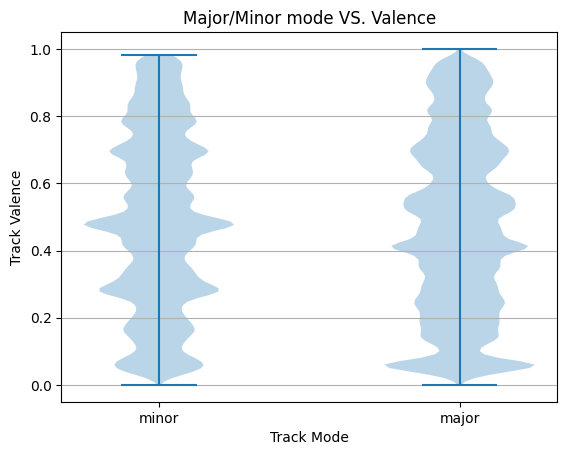

In [247]:
fig, axs = plt.subplots(1, 1)
axs.violinplot([completed[completed['trackMode']==0]['trackVal'], completed[completed['trackMode']==1]['trackVal']])
axs.yaxis.grid(True)
axs.set_xticks([1,2], labels=['minor','major'])
axs.set_xlabel('Track Mode')
axs.set_ylabel('Track Valence')

axs.set_title('Major/Minor mode VS. Valence')
plt.savefig('FIGURES/mode-valence.png', dpi=300)
plt.show()

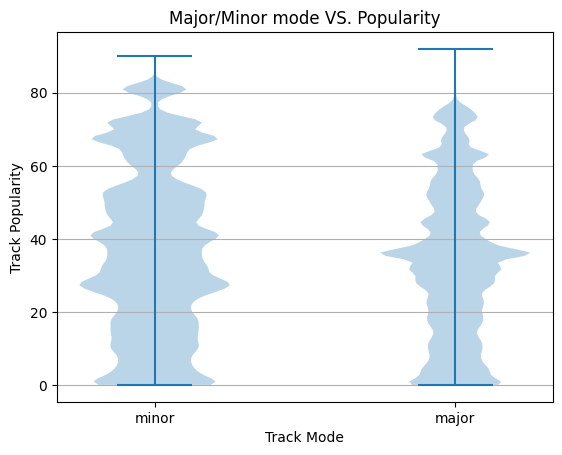

In [249]:
fig, axs = plt.subplots(1, 1)
axs.violinplot([completed[completed['trackMode']==0]['trackPop'], completed[completed['trackMode']==1]['trackPop']])
axs.yaxis.grid(True)
axs.set_xticks([1,2], labels=['minor','major'])
axs.set_xlabel('Track Mode')
axs.set_ylabel('Track Popularity')

axs.set_title('Major/Minor mode VS. Popularity')
plt.savefig('FIGURES/mode-popularity.png', dpi=300)
plt.show()

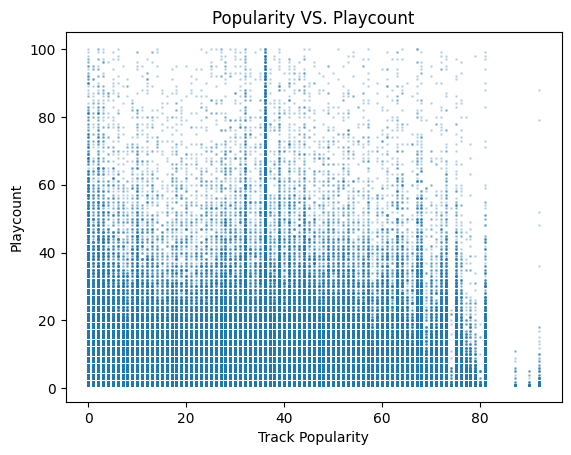

In [285]:
fig, axs = plt.subplots(1, 1)
p = axs.scatter(x=completed[completed['playcount'] <= 100]['trackPop'], y=completed[completed['playcount'] <=100]['playcount'], alpha=0.2, s=1)

axs.set_xlabel('Track Popularity')
axs.set_ylabel('Playcount')
axs.set_title('Popularity VS. Playcount')

plt.savefig('FIGURES/popularity-playcount.png', dpi=300)
plt.show()

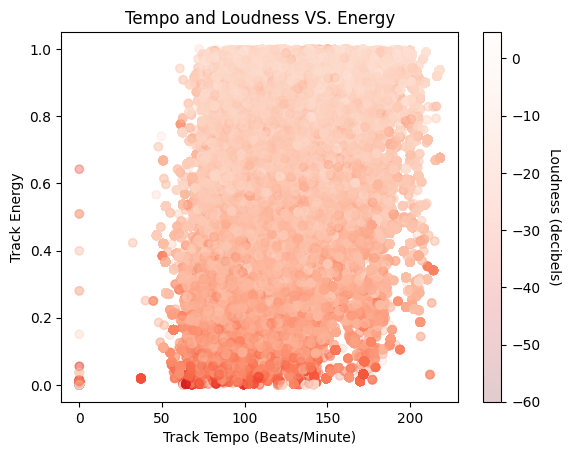

In [224]:
fig, axs = plt.subplots(1, 1)
p = axs.scatter(x=completed['trackTempo'], y=completed['trackEnergy'], alpha=0.2, c=completed['trackLoud'], cmap='Reds_r')
cbar = fig.colorbar(p,ax=axs)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Loudness (decibels)', rotation=270)
axs.set_xlabel('Track Tempo (Beats/Minute)')
axs.set_ylabel('Track Energy')
axs.set_title('Tempo and Loudness VS. Energy')

plt.savefig('FIGURES/tempo-loudness-energy.png', dpi=300)
plt.show()

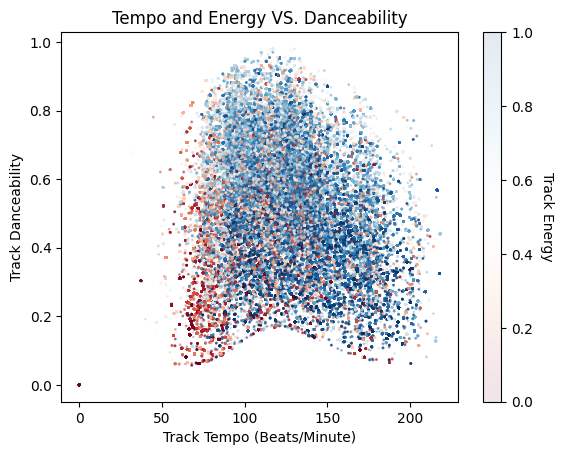

In [228]:
fig, axs = plt.subplots(1, 1)
p = axs.scatter(x=completed['trackTempo'], y=completed['trackDanceable'], alpha=0.1, s=1, c=completed['trackEnergy'], cmap='RdBu')
cbar = fig.colorbar(p,ax=axs)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Track Energy', rotation=270)
axs.set_xlabel('Track Tempo (Beats/Minute)')
axs.set_ylabel('Track Danceability')
axs.set_title('Tempo and Energy VS. Danceability')

plt.savefig('FIGURES/tempo-energy-dance.png', dpi=300)
plt.show()